# Capstone Project
## Automatic Ticket Assignement
To build a classifier that can classify the tickets by analysing text.
### Dataset
Input Data Synthetic

In [1]:
# Mount google drive

from google.colab import drive
drive.mount('/mnt/drive/')

Drive already mounted at /mnt/drive/; to attempt to forcibly remount, call drive.mount("/mnt/drive/", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Read Dataset

In [0]:
df = pd.read_excel("/mnt/drive/My Drive/Colab Notebooks/Input Data Synthetic.xlsx")

### EDA & Preprocessing

In [0]:
# Drop irrelevant columns

df = df.drop(['Caller'], axis=1)

In [5]:
df['Assignment group'].value_counts(ascending=True)

GRP_70       1
GRP_67       1
GRP_73       1
GRP_61       1
GRP_35       1
          ... 
GRP_9      252
GRP_12     257
GRP_24     289
GRP_8      661
GRP_0     3976
Name: Assignment group, Length: 74, dtype: int64

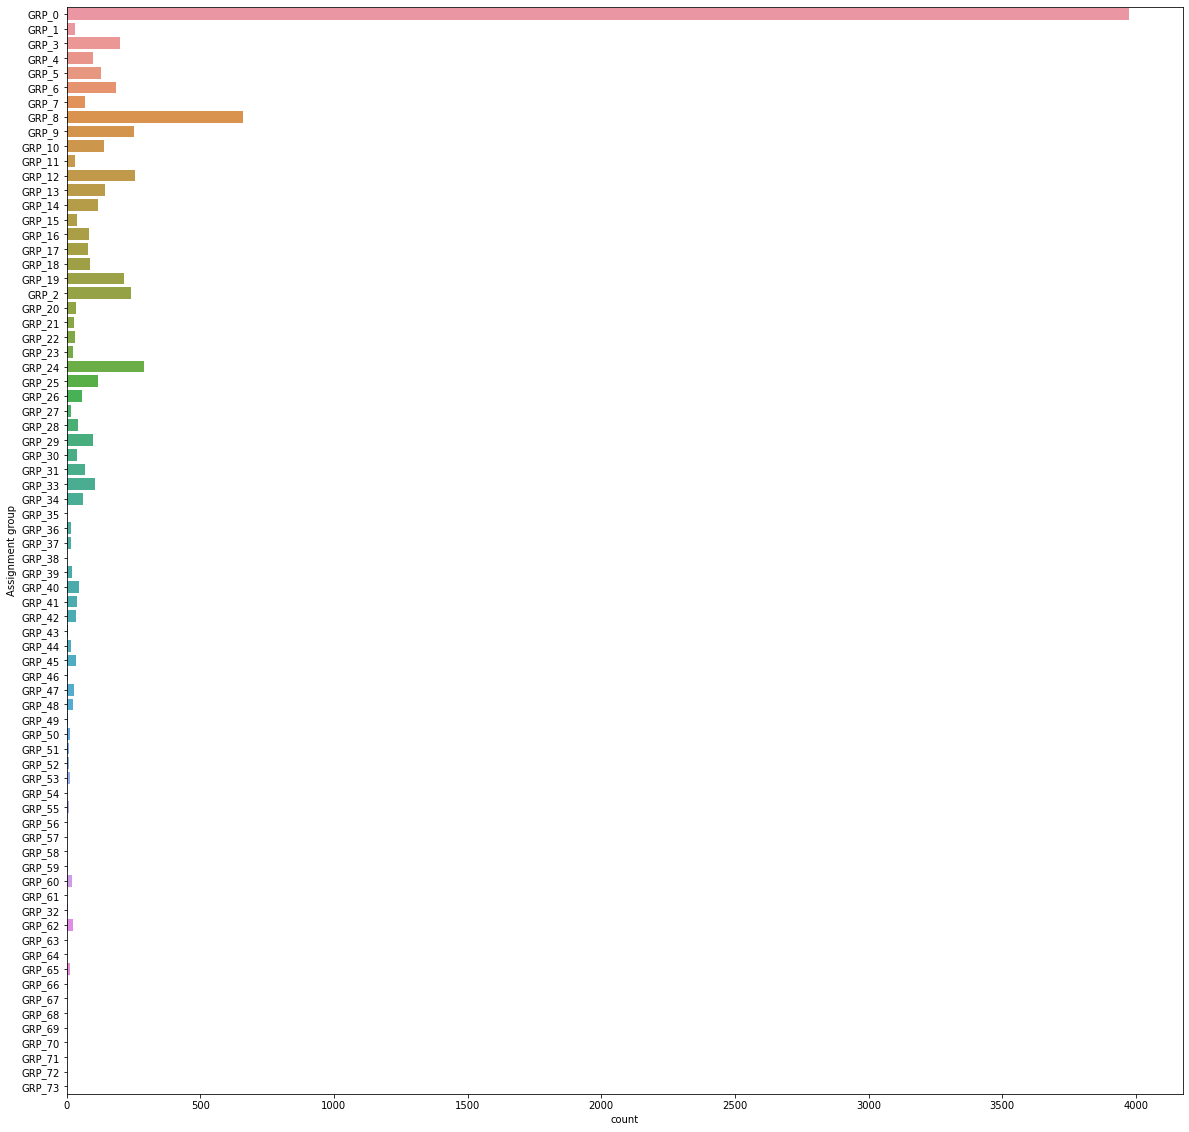

In [6]:
plt.figure(figsize=(20,20))
sns.countplot(y=df['Assignment group'])

In [0]:
# Downsample majority class


from sklearn.utils import resample

df_majority = df.loc[df['Assignment group'] == 'GRP_0']
df_minority = df.loc[df['Assignment group'] != 'GRP_0']
df_majority_downsampled = resample(df_majority, 
                        replace=False,     # sample with replacement
                        n_samples=600,    # to match majority class
                        random_state=123) # reproducible results

In [0]:
df = pd.concat([df_majority_downsampled, df_minority])

In [0]:
# Upsample minority

max_size = df['Assignment group'].value_counts().max()

lst = [df]
for class_index, group in df.groupby('Assignment group'):
    lst.append(group.sample(max_size-len(group), replace=True))
df = pd.concat(lst)

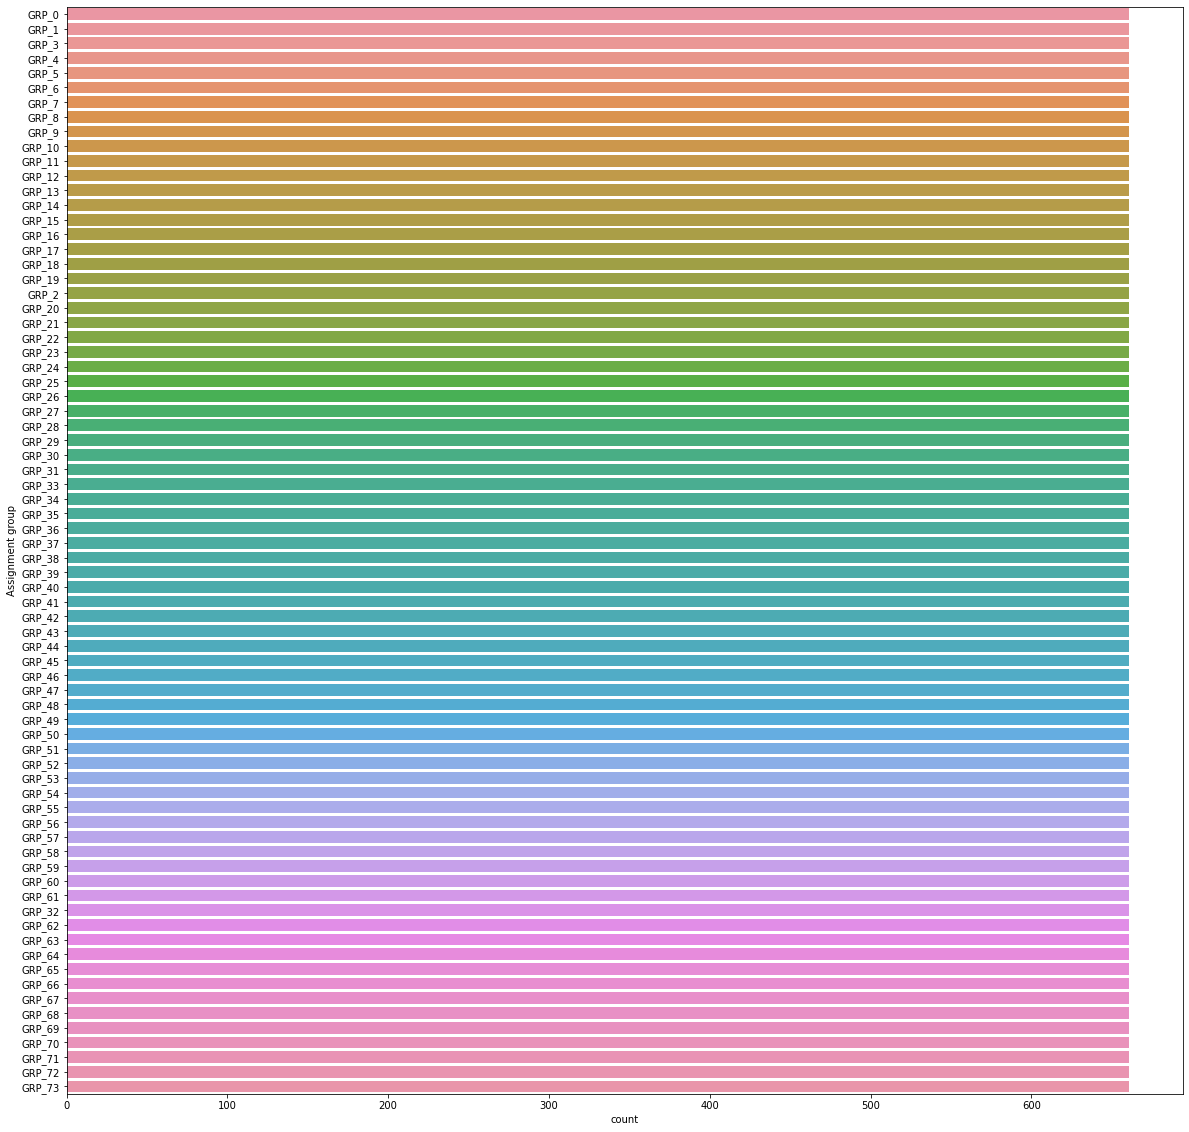

In [10]:
plt.figure(figsize=(20,20))
sns.countplot(y=df['Assignment group'])

In [11]:
# Find null values in the dataset

df[df.isna().any(axis=1)]

,Short description,Description,Assignment group
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,GRP_0
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,GRP_34
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,GRP_0
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,GRP_34
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,GRP_34
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,GRP_34
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,GRP_34
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,GRP_34
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,GRP_34
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,GRP_34


In [0]:
# Replace Null values with any stopword

df['Short description'].fillna('the', inplace=True)

In [0]:
# Change to lowercase
df['Short description'] = df['Short description'].map(lambda x: x.lower())
df['Description'] = df['Description'].map(lambda x: x.lower())

In [0]:
## Convert categories into unique codes

df['Category'] = df['Assignment group'].astype('category').cat.codes

In [0]:
df = df.drop(['Assignment group'], axis=1)

In [16]:
df.head()

,Short description,Description,Category
1822,erp sid_37 password reset,erp sid_37 password reset,0
3922,vpn login issue.,vpn login issue.\r\n-user unable tologin to v...,0
4173,erp sid_34 account locked.,erp sid_34 account locked.,0
497,backup on company provided mobile phone,backup on company provided mobile phone,0
4734,reset the password for mobaidfx gviwlsrm on er...,passwort zurã¼cksetzen -,0


In [0]:
# Remove email id from description

import re
df['Description'] = df['Description'].apply((lambda x: re.sub('received from:.\S+@\S+','',x)))

In [0]:
# Remove words that are not relevant

df['Description'] = df['Description'].apply((lambda x: re.sub('hi|hello|team|thanks|please','',x)))

In [19]:
df.head()

,Short description,Description,Category
1822,erp sid_37 password reset,erp sid_37 password reset,0
3922,vpn login issue.,vpn login issue.\r\n-user unable tologin to v...,0
4173,erp sid_34 account locked.,erp sid_34 account locked.,0
497,backup on company provided mobile phone,backup on company provided mobile phone,0
4734,reset the password for mobaidfx gviwlsrm on er...,passwort zurã¼cksetzen -,0


In [0]:
# Remove numbers

import re

df['Short description'] = df['Short description'].map(lambda x: re.sub(r'\d+', '', x))
df['Description'] = df['Description'].map(lambda x: re.sub(r'\d+', '', x))

In [21]:
df.head()

,Short description,Description,Category
1822,erp sid_ password reset,erp sid_ password reset,0
3922,vpn login issue.,vpn login issue.\r\n-user unable tologin to v...,0
4173,erp sid_ account locked.,erp sid_ account locked.,0
497,backup on company provided mobile phone,backup on company provided mobile phone,0
4734,reset the password for mobaidfx gviwlsrm on er...,passwort zurã¼cksetzen -,0


In [0]:
# Remove Punctuation

import string

df['Short description']  = df['Short description'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
df['Description']  = df['Description'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

In [23]:
df.head()

,Short description,Description,Category
1822,erp sid password reset,erp sid password reset,0
3922,vpn login issue,vpn login issue\r\nuser unable tologin to vpn...,0
4173,erp sid account locked,erp sid account locked,0
497,backup on company provided mobile phone,backup on company provided mobile phone,0
4734,reset the password for mobaidfx gviwlsrm on er...,passwort zurã¼cksetzen,0


In [0]:
# Remove white spaces

df['Short description'] = df['Short description'].map(lambda x: x.strip())
df['Description'] = df['Description'].map(lambda x: x.strip())

In [25]:
df.head()

,Short description,Description,Category
1822,erp sid password reset,erp sid password reset,0
3922,vpn login issue,vpn login issue\r\nuser unable tologin to vpn...,0
4173,erp sid account locked,erp sid account locked,0
497,backup on company provided mobile phone,backup on company provided mobile phone,0
4734,reset the password for mobaidfx gviwlsrm on er...,passwort zurã¼cksetzen,0


In [0]:
df['Description'] = df['Description'].astype(str)

In [0]:
df_description = df.Description.values

In [28]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
from nltk import word_tokenize

df['Short description'] = df['Short description'].map(lambda x: word_tokenize(x))
df['Description'] = df['Description'].map(lambda x: word_tokenize(x))

In [30]:
df.head()

,Short description,Description,Category
1822,"[erp, sid, password, reset]","[erp, sid, password, reset]",0
3922,"[vpn, login, issue]","[vpn, login, issue, user, unable, tologin, to,...",0
4173,"[erp, sid, account, locked]","[erp, sid, account, locked]",0
497,"[backup, on, company, provided, mobile, phone]","[backup, on, company, provided, mobile, phone]",0
4734,"[reset, the, password, for, mobaidfx, gviwlsrm...","[passwort, zurã¼cksetzen]",0


In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# filter out stop words

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['Short description'] = df['Short description'].map(lambda x: [w for w in x if not w in stop_words])
df['Description'] = df['Description'].map(lambda x: [w for w in x if not w in stop_words])

In [33]:
df.head()

,Short description,Description,Category
1822,"[erp, sid, password, reset]","[erp, sid, password, reset]",0
3922,"[vpn, login, issue]","[vpn, login, issue, user, unable, tologin, vpn...",0
4173,"[erp, sid, account, locked]","[erp, sid, account, locked]",0
497,"[backup, company, provided, mobile, phone]","[backup, company, provided, mobile, phone]",0
4734,"[reset, password, mobaidfx, gviwlsrm, erp, pro...","[passwort, zurã¼cksetzen]",0


In [34]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
# Word Lemmatization

from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
df['Short description'] = df['Short description'].map(lambda x: [lem.lemmatize(word,"v") for word in x])
df['Description'] = df['Description'].map(lambda x: [lem.lemmatize(word,"v") for word in x])

In [36]:
df.head()

,Short description,Description,Category
1822,"[erp, sid, password, reset]","[erp, sid, password, reset]",0
3922,"[vpn, login, issue]","[vpn, login, issue, user, unable, tologin, vpn...",0
4173,"[erp, sid, account, lock]","[erp, sid, account, lock]",0
497,"[backup, company, provide, mobile, phone]","[backup, company, provide, mobile, phone]",0
4734,"[reset, password, mobaidfx, gviwlsrm, erp, pro...","[passwort, zurã¼cksetzen]",0


In [0]:
from wordcloud import WordCloud

val = str(df.Description)

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(val)

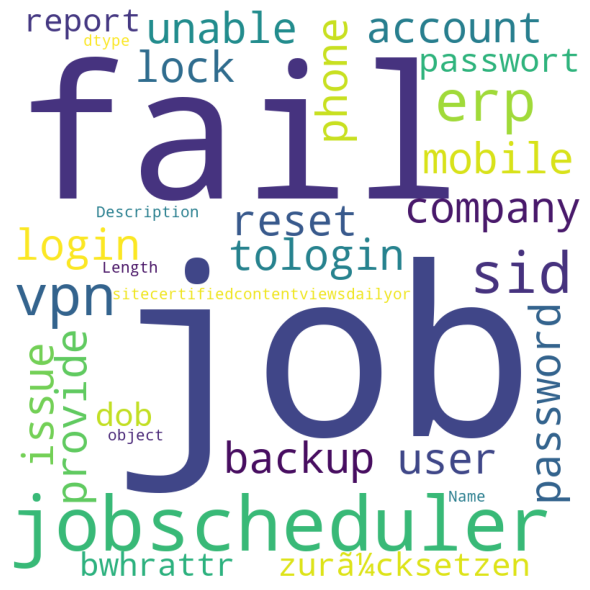

In [38]:
# plot the WordCloud image       

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [39]:
df.head()

,Short description,Description,Category
1822,"[erp, sid, password, reset]","[erp, sid, password, reset]",0
3922,"[vpn, login, issue]","[vpn, login, issue, user, unable, tologin, vpn...",0
4173,"[erp, sid, account, lock]","[erp, sid, account, lock]",0
497,"[backup, company, provide, mobile, phone]","[backup, company, provide, mobile, phone]",0
4734,"[reset, password, mobaidfx, gviwlsrm, erp, pro...","[passwort, zurã¼cksetzen]",0


In [0]:
# Turn lists back to string

df['Short description'] = df['Short description'].map(lambda x: ' '.join(x))
df['Description'] = df['Description'].map(lambda x: ' '.join(x))

In [0]:
# Concatenate short description and description columns

df['Description'] = df['Short description'].str.cat(df['Description'], sep =" ")

In [0]:
df = df.drop(['Short description'], axis=1)

In [0]:
# Find length of the words in description

df['Desc_len'] = df['Description'].apply(lambda x: len(x.split(" ")))

In [44]:
df.head()

,Description,Category,Desc_len
1822,erp sid password reset erp sid password reset,0,8
3922,vpn login issue vpn login issue user unable to...,0,27
4173,erp sid account lock erp sid account lock,0,8
497,backup company provide mobile phone backup com...,0,10
4734,reset password mobaidfx gviwlsrm erp produktio...,0,9


In [45]:
# Find maxlen 

df['Desc_len'].max()

899

In [46]:
import nltk
from nltk.tokenize import word_tokenize

desc = df.Description.str.cat(sep=' ')

tokens = word_tokenize(desc)

vocabulary = set(tokens)
print(len(vocabulary))

12784


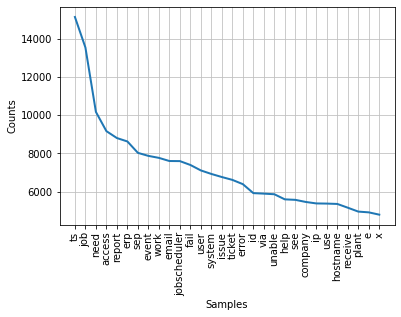

In [47]:
from nltk.probability import FreqDist

frequency_dist = nltk.FreqDist(tokens)
#sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

frequency_dist.most_common(5)

import matplotlib.pyplot as plt
frequency_dist.plot(30,cumulative=False)
plt.show()

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_features = 13000
maxlen = 900
embedding_size = 200
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['Description'].values)

### Define X and Y

In [49]:
X = tokenizer.texts_to_sequences(df['Description'])
X = pad_sequences(X, maxlen = maxlen)
y = pd.get_dummies(df['Category']).values

print('Shape of data:', X.shape)
print('Shape of label:', y.shape)

Shape of data: (48914, 900)
Shape of label: (48914, 74)


In [0]:
# Splitting into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,y, random_state = 42)

### Word Embeddings using Glove Embedding file


In [0]:
EMBEDDING_FILE = '/mnt/drive/My Drive/Colab Notebooks/Data/glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE, encoding="utf8"):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

### Weight Matrix

In [52]:
embedding_matrix = np.zeros((max_features, 200))

for word, i in tokenizer.word_index.items():
  if i >= max_features:
        continue
  embedding_vector = embeddings.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

### Model Building

In [53]:
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from keras.models import model_from_json
import os

lstm_out = 128

# Define LSTM Model

model = Sequential()
model.add(Embedding(max_features, embedding_size, weights = [embedding_matrix]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(74, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2600000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 200)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         336896    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 74)                19018     
Total params: 2,955,914
Trainable params: 2,955,914
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
# Training LSTM Model

from keras.callbacks import ModelCheckpoint

epochs = 5
batch_size = 64

filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
516/516 [==============================] - 5147s 10s/step - loss: 1.7679 - accuracy: 0.6046 - val_loss: 0.6921 - val_accuracy: 0.8264
Epoch 2/5
516/516 [==============================] - 5174s 10s/step - loss: 0.5581 - accuracy: 0.8615 - val_loss: 0.3548 - val_accuracy: 0.8983
Epoch 3/5
516/516 [==============================] - 4958s 10s/step - loss: 0.3210 - accuracy: 0.9153 - val_loss: 0.2491 - val_accuracy: 0.9324
Epoch 4/5
516/516 [==============================] - 4978s 10s/step - loss: 0.2355 - accuracy: 0.9337 - val_loss: 0.2121 - val_accuracy: 0.9384
Epoch 5/5
516/516 [==============================] - 4974s 10s/step - loss: 0.1889 - accuracy: 0.9443 - val_loss: 0.1801 - val_accuracy: 0.9479


### Training V/S Validation set accuracy plot

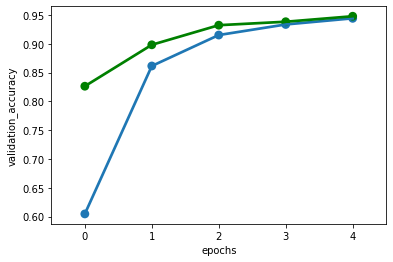

In [55]:
df_1 = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['accuracy'], 'validation_accuracy': history.history['val_accuracy']})
g = sns.pointplot(x="epochs", y="accuracy", data=df_1, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df_1, fit_reg=False, color='green')

In [56]:
predicted = model.predict(X_test)
predicted

array([[1.48579862e-03, 7.80062619e-05, 1.00110279e-04, ...,
        2.53444864e-06, 3.25477624e-04, 3.85618419e-04],
       [5.09946585e-06, 9.32989686e-09, 4.19353019e-04, ...,
        6.91892499e-09, 2.29008947e-06, 7.50170439e-05],
       [2.72421225e-04, 1.22822641e-08, 1.44981415e-04, ...,
        6.47186653e-07, 6.37274252e-06, 5.89090996e-05],
       ...,
       [1.94000622e-05, 4.58790783e-09, 4.75417164e-06, ...,
        6.38995488e-08, 1.80274892e-05, 1.40628708e-05],
       [5.25868854e-05, 1.17080822e-06, 5.79186562e-05, ...,
        6.94861413e-09, 2.11900478e-04, 5.42308735e-05],
       [2.41991020e-05, 1.50022257e-04, 2.43107844e-02, ...,
        1.60036606e-07, 1.01537205e-01, 2.08858564e-01]], dtype=float32)

In [0]:
predicted = np.argmax(predicted, axis=1)

In [0]:
Y_1 = np.argmax(Y_test, axis=1)

### Classification report

In [59]:
from sklearn.metrics import classification_report
print(classification_report(Y_1, predicted))

              precision    recall  f1-score   support

           0       0.79      0.47      0.59       172
           1       0.85      1.00      0.92       162
           2       0.96      0.83      0.89       178
           3       1.00      1.00      1.00       179
           4       0.97      0.75      0.85       171
           5       0.94      0.94      0.94       178
           6       0.94      0.99      0.96       147
           7       0.99      1.00      0.99       152
           8       0.99      1.00      1.00       173
           9       1.00      1.00      1.00       152
          10       0.93      0.92      0.92       161
          11       0.75      0.91      0.82       170
          12       0.96      0.88      0.92       156
          13       1.00      1.00      1.00       147
          14       0.99      1.00      0.99       151
          15       0.99      1.00      1.00       176
          16       0.98      1.00      0.99       165
          17       0.96    